**Training the GAN Augmented CNN**

32/32 [==============================] - 12s 363ms/step
Epoch 1/20
1294/1294 [==============================] - 131s 100ms/step - loss: 0.1951 - accuracy: 0.9176 - val_loss: 0.0771 - val_accuracy: 0.9702
Epoch 2/20
1294/1294 [==============================] - 123s 95ms/step - loss: 0.0364 - accuracy: 0.9870 - val_loss: 0.0450 - val_accuracy: 0.9847
Epoch 3/20
1294/1294 [==============================] - 124s 96ms/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.0528 - val_accuracy: 0.9847
Epoch 4/20
1294/1294 [==============================] - 123s 95ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.0493 - val_accuracy: 0.9847
Epoch 5/20
1294/1294 [==============================] - 123s 95ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0881 - val_accuracy: 0.9812
Epoch 6/20
1294/1294 [==============================] - 124s 96ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0615 - val_accuracy: 0.9860
Epoch 7/20
1294/1294 [==============================] - 124s 

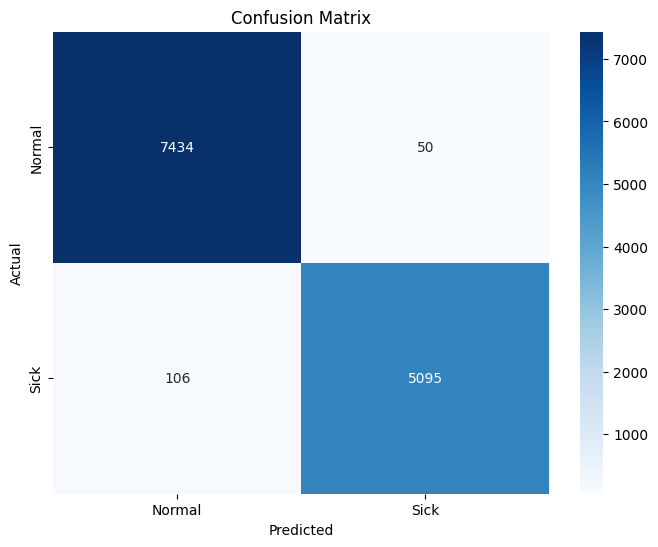

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      7484
        Sick       0.99      0.98      0.98      5201

    accuracy                           0.99     12685
   macro avg       0.99      0.99      0.99     12685
weighted avg       0.99      0.99      0.99     12685



In [ ]:


# Step 4: Train the CNN on Combined Dataset
# Generate images using the trained generator
num_generated_images = 3000
noise = np.random.normal(0, 1, (num_generated_images, 100))
generated_images = generator.predict(noise)

# Combine original and generated datasets
X_combined = np.concatenate((X_train, generated_images))
y_combined = np.concatenate((y_train, np.zeros(num_generated_images)))  # Generated images labeled '0'

# Split combined dataset
X_train_final, X_val, y_train_final, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Build and compile CNN
def build_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

cnn = build_cnn()
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
cnn.fit(X_train_final, y_train_final, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Step 5: Evaluate the Model
y_pred = (cnn.predict(X_test) > 0.5).astype("int32")

# Step 6: Confusion Matrix and Recall
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Sick'], yticklabels=['Normal', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Normal', 'Sick'])
print("Classification Report:\n", report)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Step 1: Load and Preprocess MRI Images
def load_mri_data(data_dir):
    images = []
    labels = []

    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is loaded properly
                    img = cv2.resize(img, (128, 128))  # Resize to 128x128
                    images.append(img)
                    labels.append(1 if label == 'sick' else 0)  # Binary labels

    images = np.array(images) / 255.0  # Normalize pixel values
    labels = np.array(labels)
    return images, labels

# Load data
data_dir = 'path/to/dataset'  # Change this to your dataset path
X, y = load_mri_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Build the GAN
# Generator
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(128 * 32 * 32, activation='relu', input_dim=100))
    model.add(layers.Reshape((32, 32, 128)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2D(3, (7, 7), activation='sigmoid', padding='same'))
    return model

# Discriminator
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(128, 128, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Compile GAN
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

generator = build_generator()
z = layers.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

gan = models.Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Step 3: Train the GAN
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

train_gan(epochs=10000, batch_size=32)

# Step 4: Train the CNN on Combined Dataset
# Generate images using the trained generator
num_generated_images = 5000
noise = np.random.normal(0, 1, (num_generated_images, 100))
generated_images = generator.predict(noise)

# Combine original and generated datasets
X_combined = np.concatenate((X_train, generated_images))
y_combined = np.concatenate((y_train, np.zeros(num_generated_images)))  # Generated images labeled '0'

# Split combined dataset
X_train_final, X_val, y_train_final, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Build and compile CNN
def build_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

cnn = build_cnn()
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
cnn.fit(X_train_final, y_train_final, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Step 5: Evaluate the Model
y_pred = (cnn.predict(X_test) > 0.5).astype("int32")

# Step 6: Confusion Matrix and Recall
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Sick'], yticklabels=['Normal', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Normal', 'Sick'])
print("Classification Report:\n", report)